In [1]:
import traceback
import ujson
import time
import pendulum
import pandas as pd
import numpy as np
import re
from unicodedata import normalize
from itertools import product
import time
import pickle
import matplotlib.pyplot as plt
import math

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 500)
pd.set_option('display.width',2000)
pd.set_option('display.max_rows', 500)

## CSVデータの読み込み

In [2]:
column_names = [
    'no',  # No
    'code',  # 全国地方公共団体コード
    'prefecture',  # 都道府県名
    'published_at',   # 公表年月日
    'infected_at',   # 感染確認年月日
    'patients_area',  # 患者居住地
    'patients_age',  # 患者年代
    'patients_sex',  # 患者性別
]

df_csv = pd.read_csv(
    './master_data/csv/yamagata_patients.csv',
    na_values= ['−'], 
    # dtype={}
    names = column_names,  # ヘッダー行が無い場合に使う
    skiprows=1
)

## 使用しないフィールドを削除
# del df_csv['no']
del df_csv['code']
del df_csv['prefecture']
#df_csv = df_csv.dropna(how='any')
# display(df_csv.loc[
#     (df_csv.published_at == '欠番') | 
#     (df_csv.patients_area.isnull()) | 
#     (df_csv.patients_age.isnull()) |
#     (df_csv.patients_sex.isnull())
# ])
df_csv = df_csv.dropna(subset=['patients_area', 'patients_age'])



## 追加のデータ（発表データ）


In [3]:
# -- 発表日と感染確認日を日付型に変換
df_csv['published_at'] = pd.to_datetime(
    df_csv['published_at'], 
    format='%Y/%m/%d', 
    infer_datetime_format=True
)
df_csv['infected_at'] = pd.to_datetime(
    df_csv['infected_at'], 
    format='%Y/%m/%d', 
    infer_datetime_format=True
)

### 人口データの読み込み

In [4]:
raw_df = pd.read_excel('./master_data/population/r40301.xlsx')
df_pop = raw_df.iloc[16:,62:]  # 固定位置でスライス
columns = [
    '市町村名','総数', '男', '女', '自然動態_出生', '自然動態_死亡', '自然動態_増減', 
    '社会動態_転入', '社会動態_転出', '社会動態_増減', '総増減', '世帯数', '世帯数_増減',
    # 'dummy_1', 'dummy_2'  # 月によってかわる
]
df_pop.columns = columns
# del df_pop['dummy_1']
# del df_pop['dummy_2']
df_pop = df_pop.dropna(how='all')
df_pop['市町村名'] = df_pop['市町村名'].str.replace(' ', '', regex=False)
df_pop['人口'] = df_pop['総数'].astype(int)
df_pop['pop_per10'] = round(df_pop['人口'] / 100000, 2)

# -- エリア設定
shonai = ['鶴岡市', '酒田市', '庄内町', '三川町', '遊佐町']
df_pop.loc[df_pop['市町村名'].isin(shonai), 'area'] = '庄内'
murayama = ['山形市', '寒河江市', '天童市', '東根市', '上山市', '山辺町', '中山町', '尾花沢市', '村山市', '朝日町', '大江町', '河北町', '大石田町', '西川町']
df_pop.loc[df_pop['市町村名'].isin(murayama), 'area'] = '村山'    
mogami = ['鮭川村', '新庄市', '最上町', '金山町', '真室川町', '戸沢村', '大蔵村', '舟形町']
df_pop.loc[df_pop['市町村名'].isin(mogami), 'area'] = '最上'    
okitama = ['小国町', '白鷹町', '飯豊町', '長井市', '南陽市', '川西町', '高畠町', '米沢市']
df_pop.loc[df_pop['市町村名'].isin(okitama), 'area'] = '置賜'    

# -- 市町村のリストに合わせて地方別に集計
shonai_population = df_pop.loc[df_pop.area == '庄内']['人口'].sum()
murayama_population = df_pop.loc[df_pop.area == '村山']['人口'].sum()
mogami_population = df_pop.loc[df_pop.area == '最上']['人口'].sum()
okitama_population = df_pop.loc[df_pop.area == '置賜']['人口'].sum()

yamagata_population = shonai_population + murayama_population + mogami_population + okitama_population
tsuruoka_population = df_pop.loc[df_pop['市町村名'] == '鶴岡市']['人口'].iloc[0]

df_pop_ = df_pop[['市町村名', '人口', 'pop_per10']].copy()
df_pop_ = df_pop_.reset_index(drop=True)

# display(df_pop_)
display('庄内の人口: ' + str(shonai_population))
display('村山の人口: ' + str(murayama_population))
display('置賜の人口: ' + str(okitama_population))
display('最上の人口: ' + str(mogami_population))
display('山形県の人口: ' + str(yamagata_population))
display('鶴岡市の人口:' + str(tsuruoka_population))

'庄内の人口: 258125'

'村山の人口: 524907'

'置賜の人口: 197885'

'最上の人口: 68703'

'山形県の人口: 1049620'

'鶴岡市の人口:119862'

## 1週間単位の合計 (2022-01-02から)

In [5]:
df_range = df_csv.loc[df_csv.infected_at > '2022-01-02'].copy()  # 2022-01-02 is Sunday
df_range['day_of_week'] = df_range.published_at.dt.strftime('%a')

In [6]:
# -- 移動合計から日曜日だけの数字を抜き出す
range_days = 7
start_date = pendulum.parse('2022-01-02', tz='Asia/Tokyo')
end_date = pendulum.now(tz='Asia/Tokyo')
if end_date.strftime('%a') != 'Sun':  # 週の途中は次の日曜日までを対象とする
    count = 0
    while True:
        tg = end_date.add(days=count)
        if tg.strftime('%a') == 'Sun':
            end_date = tg
            break
        count += 1
        
period = pendulum.period(start_date, end_date)

ts_yamagata = []  # 山形県
ts_tsuruoka = []  # 鶴岡市
ts_shonai = []

for dt in period.range('days'):  # 月曜から日曜までの合計を計算
    past_date = dt.subtract(days=range_days).strftime('%Y-%m-%d')
    tagt_date = dt.strftime('%Y-%m-%d')
    # print(past_date, tagt_date)
    if dt.strftime('%a') != 'Sun':
        continue  # 日曜日以外はスキップ
    df_recent = df_range.loc[
        (df_csv.published_at>past_date) & 
        (df_csv.published_at<=tagt_date)
    ].copy()
    sr_sum = df_recent.patients_area.value_counts()  # 市町村ごとのカウント
    df_sum = sr_sum.to_frame().reset_index()
    df_sum.columns = ['市町村名', '感染者数合計']
    yamagata_sum = df_sum['感染者数合計'].sum()  # 全体の合計 == 山形県の合計
    df_tsuruoka = df_sum.loc[df_sum['市町村名'] == '鶴岡市']  # 鶴岡市のみを抜き出す
    df_shonai = df_sum.loc[df_sum['市町村名'].isin(shonai)]  # 庄内地方のみを抜き出す
    tsuruoka_sum = df_tsuruoka['感染者数合計'].iloc[0] if len(df_tsuruoka) else 0
    shonai_sum = df_shonai['感染者数合計'].sum() if len(df_shonai) else 0

    ts_yamagata.append({'日付': tagt_date, '感染者数合計': yamagata_sum})
    ts_tsuruoka.append({'日付': tagt_date, '感染者数合計': tsuruoka_sum})
    ts_shonai.append({'日付': tagt_date, '感染者数合計': shonai_sum})
        
df_ts_yamagata = pd.DataFrame(ts_yamagata)
df_ts_tsuruoka = pd.DataFrame(ts_tsuruoka)
df_ts_shonai = pd.DataFrame(ts_shonai)

yamagata_sum = df_ts_yamagata['感染者数合計'].sum()
tsuruoka_sum = df_ts_tsuruoka['感染者数合計'].sum()
shonai_sum = df_ts_shonai['感染者数合計'].sum()

In [7]:
from IPython.display import display, HTML
# display(df_recent_shonai_pivot)
print('山形県全体')
display(HTML(df_ts_yamagata.to_html()))
print('計：', yamagata_sum, '人口割合', round(yamagata_sum / yamagata_population * 100, 2), '%')
print('庄内地方')
display(HTML(df_ts_shonai.to_html()))
print('計：', shonai_sum, '人口割合', round(shonai_sum / shonai_population * 100, 2), '%')
print('鶴岡市のみ')
display(HTML(df_ts_tsuruoka.to_html()))
print('計：', tsuruoka_sum, '人口割合', round(tsuruoka_sum / tsuruoka_population * 100, 2), '%')


山形県全体


,日付,感染者数合計
0,2022-01-02,0
1,2022-01-09,34
2,2022-01-16,201
3,2022-01-23,412
4,2022-01-30,1239
5,2022-02-06,1844
6,2022-02-13,1397
7,2022-02-20,1447
8,2022-02-27,1291
9,2022-03-06,1321


計： 14359 人口割合 1.37 %
庄内地方


,日付,感染者数合計
0,2022-01-02,0
1,2022-01-09,5
2,2022-01-16,46
3,2022-01-23,225
4,2022-01-30,702
5,2022-02-06,886
6,2022-02-13,606
7,2022-02-20,429
8,2022-02-27,282
9,2022-03-06,300


計： 4906 人口割合 1.9 %
鶴岡市のみ


,日付,感染者数合計
0,2022-01-02,0
1,2022-01-09,1
2,2022-01-16,6
3,2022-01-23,61
4,2022-01-30,400
5,2022-02-06,443
6,2022-02-13,248
7,2022-02-20,163
8,2022-02-27,138
9,2022-03-06,190


計： 2485 人口割合 2.07 %


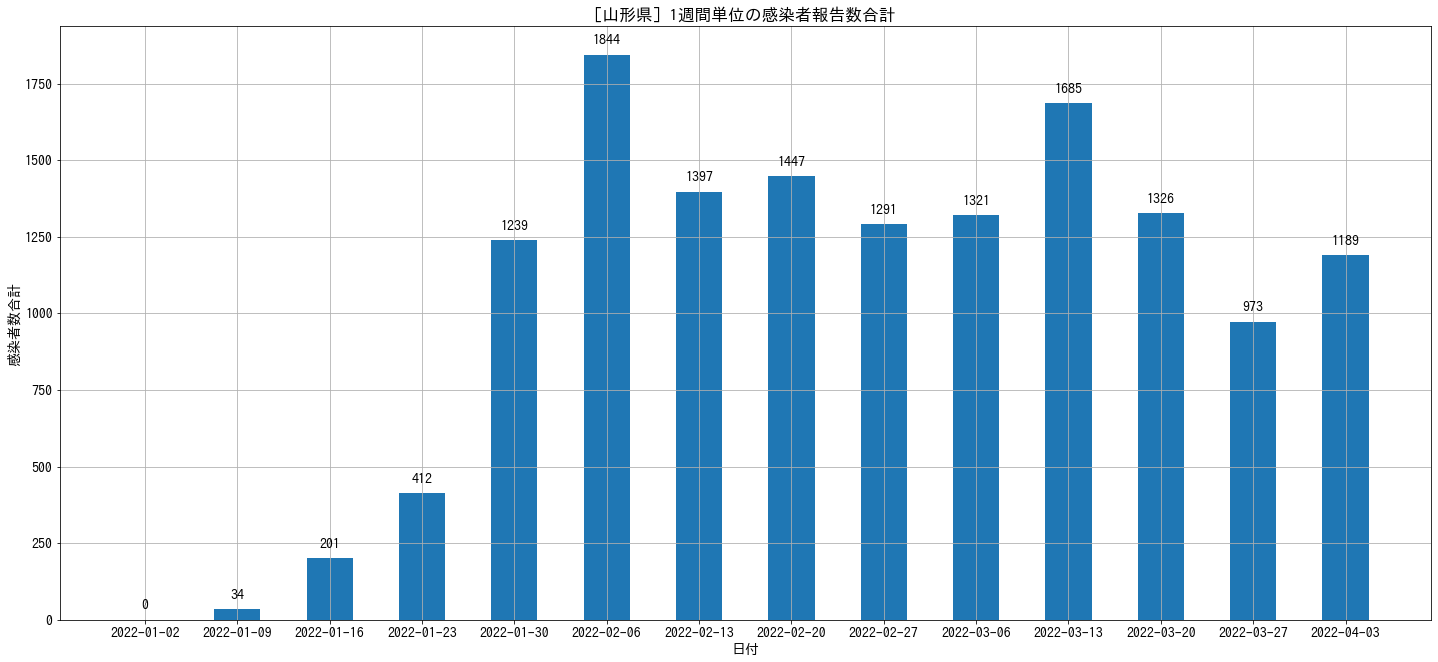

In [8]:
# -- バーチャート 山形県全体
plt.rcParams["font.family"] = "TakaoGothic"
plt.rcParams["figure.figsize"] = (20, 9)
plt.rcParams["font.size"] = 14
fig, ax = plt.subplots()
plt.tight_layout()
plt.bar(df_ts_yamagata['日付'],df_ts_yamagata['感染者数合計'], width=0.5)
plt.grid(True)

ax.set(
    title = f'[山形県] 1週間単位の感染者報告数合計',
    ylabel = "感染者数合計",
    xlabel = "日付"
)

for x,y in zip(df_ts_yamagata['日付'],df_ts_yamagata['感染者数合計']):
    label = "{:.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('bar_yamagata_patients_by_week.png', dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)
plt.show()

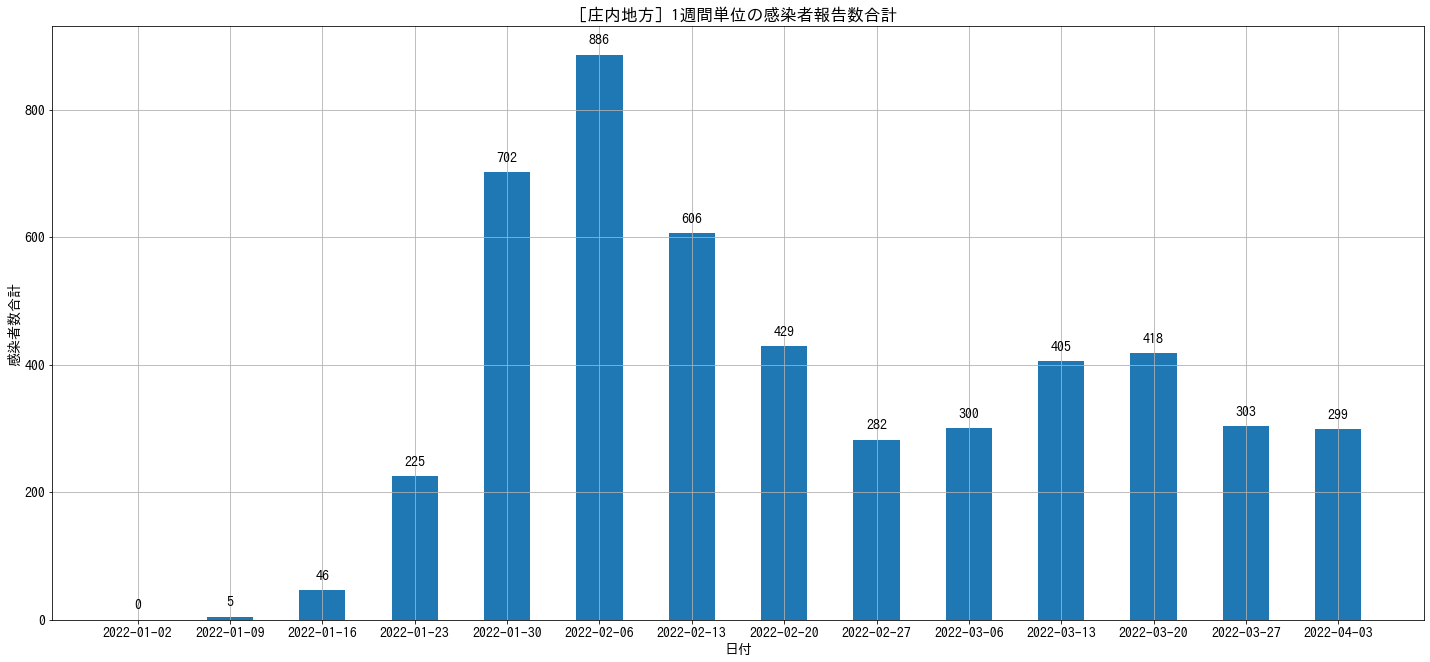

In [9]:
# -- バーチャート 庄内地方
plt.rcParams["font.family"] = "TakaoGothic"
plt.rcParams["figure.figsize"] = (20, 9)
plt.rcParams["font.size"] = 14
fig, ax = plt.subplots()
plt.tight_layout()
plt.bar(df_ts_shonai['日付'],df_ts_shonai['感染者数合計'], width=0.5)
plt.grid(True)

ax.set(
    title = f'[庄内地方] 1週間単位の感染者報告数合計',
    ylabel = "感染者数合計",
    xlabel = "日付"
)

for x,y in zip(df_ts_shonai['日付'],df_ts_shonai['感染者数合計']):
    label = "{:.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('bar_shonai_patients_by_week.png', dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)

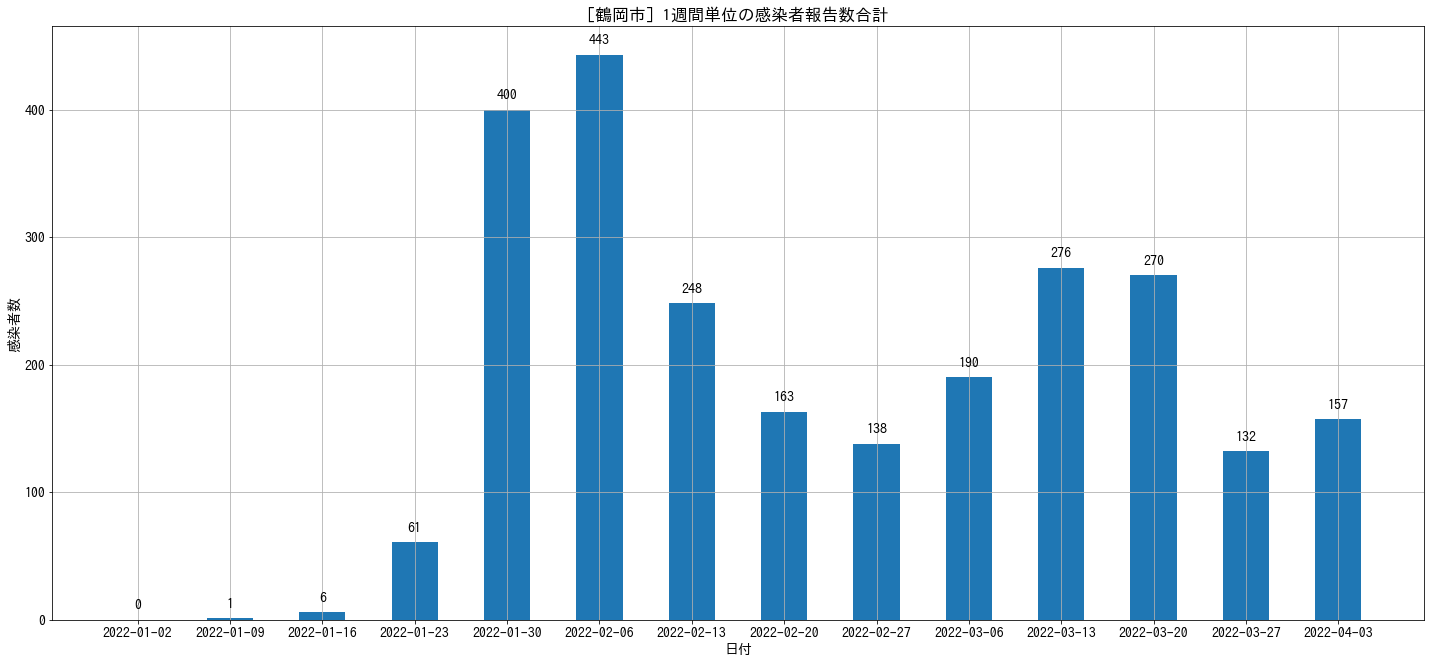

In [10]:
# -- バーチャート 鶴岡市
plt.rcParams["font.family"] = "TakaoGothic"
plt.rcParams["figure.figsize"] = (20, 9)
plt.rcParams["font.size"] = 14
fig, ax = plt.subplots()
plt.tight_layout()
plt.bar(df_ts_tsuruoka['日付'],df_ts_tsuruoka['感染者数合計'], width=0.5)
plt.grid(True)

ax.set(
    title = f'[鶴岡市] 1週間単位の感染者報告数合計',
    ylabel = "感染者数",
    xlabel = "日付"
)

for x,y in zip(df_ts_tsuruoka['日付'],df_ts_tsuruoka['感染者数合計']):
    label = "{:.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('bar_tsuruoka_patients_by_week.png', dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)
plt.show()